In [2]:
!cp /content/drive/My\ Drive/Colab\ Notebooks/abc.zip /content

In [3]:
from zipfile import ZipFile
with ZipFile('abc.zip','r') as zip:
	zip.extractall()

In [4]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=a0782d9a589b6ef2a986b128511629c118aa81ec097ad9b4320798ec24456fc8
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 119.5 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [6]:
import tensorflow
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from tensorflow.keras.layers import Input, Lambda, Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'2.3.0'

In [15]:
IMAGE_SIZE=[224,224]

In [16]:
train_path='abc/train'
test_path='abc/test'
validation_path='abc/validation'

In [46]:
vgg=VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [47]:
for layer in vgg.layers:
    layer.trainable=False

In [48]:
folders=glob('abc/train/*')
folders

['abc/train/dogs', 'abc/train/cats']

In [49]:
x=Flatten()(vgg.output)

In [50]:
prediction=Dense(len(folders),activation='softmax')(x)

In [69]:
model=Model(inputs=vgg.input,outputs=prediction)

In [70]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [71]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [72]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen=ImageDataGenerator(
    rescale=1./255
)
val_datagen=ImageDataGenerator(
    rescale=1./255
)

In [73]:
training_set=train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)
test_set=test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)
val_set=val_datagen.flow_from_directory(
    validation_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [74]:
r=model.fit_generator(
    training_set,
    validation_data=val_set,
    epochs=4,
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set)
)

Epoch 1/4
188/188 [==============================] - 86s 459ms/step - loss: 0.1327 - accuracy: 0.9478 - val_loss: 0.2168 - val_accuracy: 0.9320
Epoch 2/4
188/188 [==============================] - 86s 458ms/step - loss: 0.0970 - accuracy: 0.9622 - val_loss: 0.5410 - val_accuracy: 0.8505
Epoch 3/4
188/188 [==============================] - 86s 456ms/step - loss: 0.1134 - accuracy: 0.9573 - val_loss: 0.2845 - val_accuracy: 0.9190
Epoch 4/4
188/188 [==============================] - 86s 455ms/step - loss: 0.1050 - accuracy: 0.9592 - val_loss: 0.2422 - val_accuracy: 0.9365


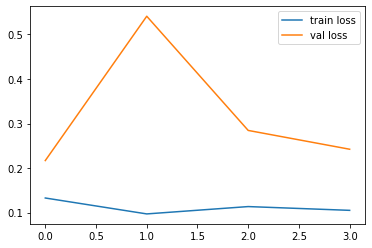

In [75]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()
plt.show()

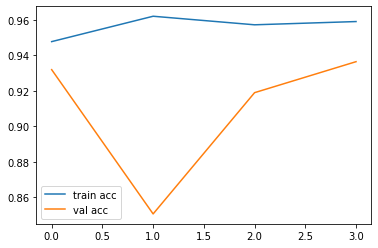

In [76]:
plt.plot(r.history['accuracy'],label='train acc')
plt.plot(r.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()

In [77]:
model.save('final.h5')

In [78]:
test_pred=model.predict(test_set)

0


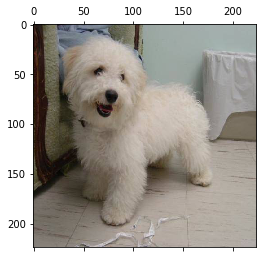

In [79]:
print(np.argmax(test_pred[15])) #0 is cat 1 is dog
plt.matshow(test_set[0][0][15])

In [80]:
test_pred

array([[2.83649433e-06, 9.99997139e-01],
       [1.09989315e-07, 9.99999881e-01],
       [1.25647803e-05, 9.99987483e-01],
       ...,
       [8.77540350e-01, 1.22459710e-01],
       [2.45207277e-09, 1.00000000e+00],
       [9.96585131e-01, 3.41483415e-03]], dtype=float32)

In [81]:
model.evaluate(test_set)

63/63 [==============================] - 8s 134ms/step - loss: 0.2700 - accuracy: 0.9220


[0.27003878355026245, 0.921999990940094]

In [82]:
!cp /content/final.h5 /content/drive/My\ Drive/Colab\ Notebooks